In [66]:
using QuantumOptics
using PyPlot
using Statistics
using LinearAlgebra
using CollectiveSpins

### Functions

In [67]:
""" Prepare the initial state of the system 
with a phase correlation imposed between the atoms
because the laser arrive on the lattice with an angle θl """
function prepare_phi_IS(θl, λl, theta_array)
    phi_array = zeros(N)
    for i = 1:N
        phi_array[i] = 2pi * sqrt(sum((system.spins[i].position .* [cos(θl), sin(θl), 0]) .^ 2))
    end
    return phi_array
end

prepare_phi_IS

# MPC Computations

### Defining the system

In [68]:
# Define geometry of system
Nx,Ny,Nz = [5,5,3]
N = Nx*Ny*Nz;
d_xy, d_z = 266., 532. # Optical lattice spacing in nm

# Define computation variables
λl = 1299. # Frequency of the laser
θl = 30*pi/180 # Angle of the laser
Γ0 = 1. # SE decay rate

# Define the system
a_dim,b_dim,c_dim = [d_xy,d_xy,d_z]/λl
geo = CollectiveSpins.geometry.box(a_dim,b_dim,c_dim;Nx=Nx,Ny=Ny,Nz=Nz)
e = [0,0,1]   # Quantization axis
system = CollectiveSpins.SpinCollection(geo, e, gammas=1.)

Tstep, Tend = 1e-3, 1 # Normalised by Γ0
T = [0:Tstep:Tend;];

In [69]:
# Prepare the initial state
theta_array = ones(N)*pi/2
phi_array = prepare_phi_IS(θl, λl, theta_array)
Ψ0 = CollectiveSpins.mpc.blochstate(phi_array, theta_array)
Ψ0_nocorr = CollectiveSpins.mpc.blochstate(phi_array*0, theta_array);

### Plot the initial state

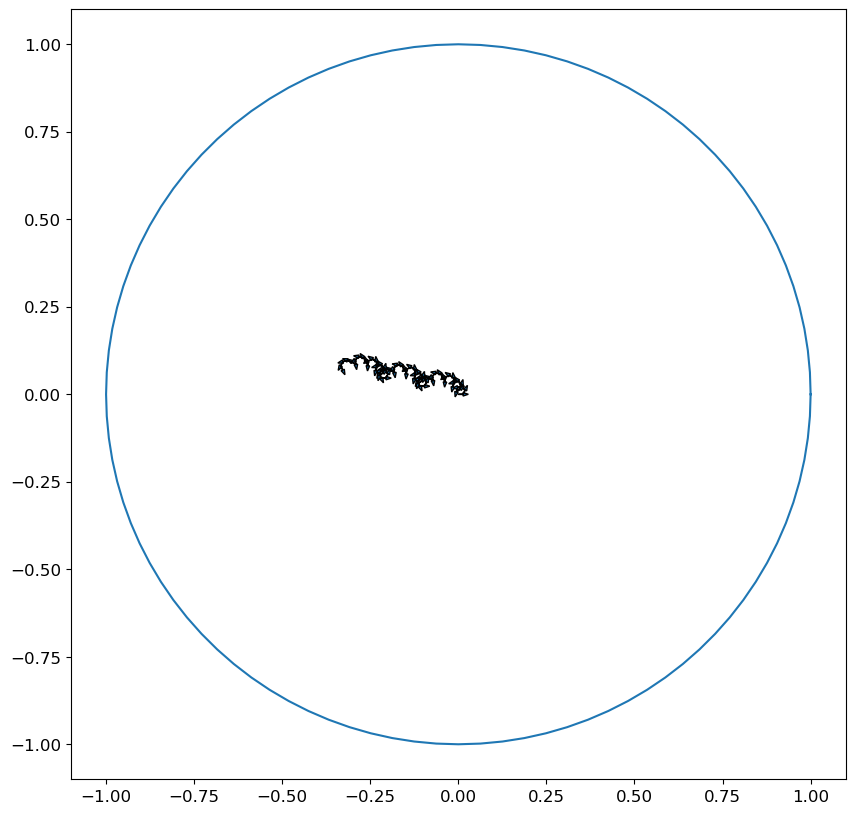

In [70]:
close("all")
figure(figsize=(10, 10))

# Plot a circle
N_circle = 100
plot(cos.(2pi*(0:N_circle)/N_circle), sin.(2pi*(0:N_circle)/N_circle), lw=1.5)

x, y = 0, 0
 for i = 1:N
    dx, dy = cos(phi_array[i])/N, sin(phi_array[i])/N
    arrow(x, y, dx, dy, head_width=0.01)
    x += dx
    y += dy
 end
 pygui(false); gcf()
 #pygui(true); show()

### Computations

In [71]:
ρt_MPC = CollectiveSpins.mpc.timeevolution(T, system, Ψ0, dt=Tstep)[2]
ρt_MPC_nocorr = CollectiveSpins.mpc.timeevolution(T, system, Ψ0_nocorr, dt=Tstep)[2];;

In [72]:
# Compute in the independent case
Ψ0_ind = CollectiveSpins.independent.blochstate(phi_array[1], theta_array[1], N)
ρt_ind = CollectiveSpins.independent.timeevolution(T, system, Ψ0_ind, dt=Tstep)[2];

In [73]:
# Compute <σz> for each λ and each t
meanSzt_MPC = [-1 *(mean(CollectiveSpins.mpc.sz(ρ))+1) /2 - 6 for ρ in ρt_MPC]
decayRatet_MPC = diff(meanSzt_MPC)/Tstep

meanSzt_MPC_nocorr = [-1 *(mean(CollectiveSpins.mpc.sz(ρ))+1) /2 - 6 for ρ in ρt_MPC_nocorr]
decayRatet_MPC_nocorr = diff(meanSzt_MPC_nocorr)/Tstep

# Compute the independent case
Szt_ind = [-1 *(mean(CollectiveSpins.independent.sz(ρ))+1) /2 - 6  for ρ in ρt_ind]
meanSzt_ind = [mean(subarray) for subarray in Szt_ind]
decayRatet_ind = diff(meanSzt_ind)/Tstep;

### Plots

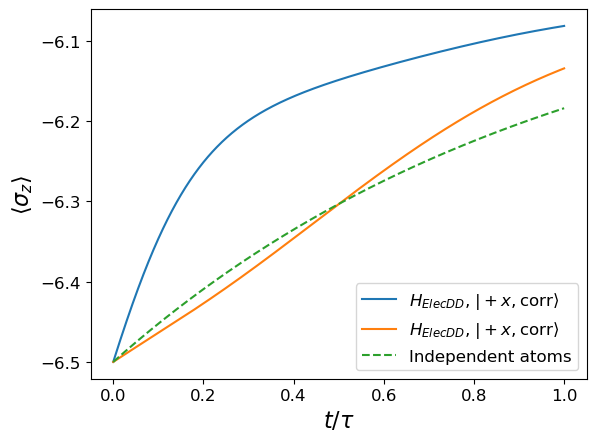

In [77]:
close("all")
figure()

PyPlot.rc("font", size = 12)

plot(T, meanSzt_MPC, label=L"$H_{ElecDD}$, $|+x, \text{corr}\rangle$")
plot(T, meanSzt_MPC_nocorr, label=L"$H_{ElecDD}$, $|+x, \text{corr}\rangle$")
plot(T, meanSzt_ind, label=string("Independent atoms"), linestyle="--")
#title("Evolution of the mean spin for fully inverted system")
xlabel(L"t/\tau", fontsize=16)
ylabel(L"\langleσ_z\rangle", fontsize=16)
legend()

savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/Pop_decay_mean_sigmaz_phase_relationship.pdf", bbox_inches="tight")

pygui(false); gcf()

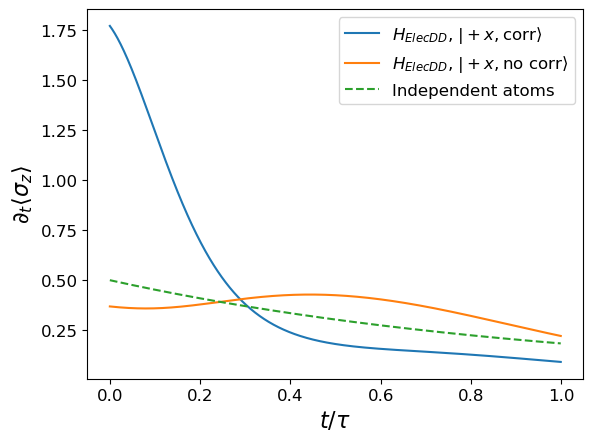

In [79]:
close("all")
figure()


plot(T[1:end-1], decayRatet_MPC, label=L"$H_{ElecDD}$, $|+x, \text{corr}\rangle$")
plot(T[1:end-1], decayRatet_MPC_nocorr, label=L"$H_{ElecDD}$, $|+x, \text{no corr}\rangle$")
plot(T[1:end-1], decayRatet_ind, label=string("Independent atoms"), linestyle="--")
#title("Rates of the mean spin for fully inverted system")
xlabel(L"t/\tau", fontsize=16)
ylabel(L"\partial_t{\langle \sigma_z\rangle}", fontsize=16)
legend()

savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/Pop_decay_diff_mean_sigmaz_phase_relationship.pdf", bbox_inches="tight")

pygui(false); gcf()